## Data Discovery

Data discovery of the energy forecast.

In [1]:
from google.datalab import bigquery as bq
import pandas as pd

In [5]:
query_1 = """
SELECT 
  sl.point,
  sl.lat,
  sl.long,
  f.prediction_date,
  f.wind_speed_100m,
  f.wind_direction_100m,
  f.temperature,
  f.air_density,
  f.pressure,
  f.precipitation,
  f.wind_gust,
  f.radiation,
  f.wind_speed,
  f.wind_direction,
  f.price
FROM
  (SELECT 
      h.prediction_date,
      p.price,
      h.wind_speed_100m,
      h.wind_direction_100m,
      h.temperature,
      h.air_density,
      h.pressure,
      h.precipitation,
      h.wind_gust,
      h.radiation,
      h.wind_speed,
      h.wind_direction,
      h.point
   FROM
      `energy.historical_forecasting` as h
   JOIN
      `energy.market_price` as p
   ON
      p.date = h.prediction_date
  ) as f
JOIN
  `energy.station_location` as sl
ON
  f.point = sl.point
ORDER BY
  f.prediction_date
"""

query = """
SELECT 
  f.prediction_date,
  AVG(f.wind_speed_100m) as avg_wind_speed_100m,
  AVG(f.wind_direction_100m) as avg_wind_direction_100m,
  AVG(f.temperature) as avg_temperature,
  AVG(f.air_density) as avg_air_density,
  AVG(f.pressure) as avg_pressure,
  AVG(f.precipitation) as avg_precipitation,
  AVG(f.wind_gust) as avg_wind_gust,
  AVG(f.radiation) as avg_radiation,
  AVG(f.wind_speed) as avg_wind_speed,
  AVG(f.wind_direction) as avg_wind_direction,
  AVG(p.price) as price
FROM
   `energy.historical_forecasting` as f
JOIN
   `energy.market_price` as p
ON
   p.date = f.prediction_date
GROUP BY
  f.prediction_date
ORDER BY
  f.prediction_date
"""

df = bq.Query(query).execute().result().to_dataframe()
df.describe()

,avg_wind_speed_100m,avg_wind_direction_100m,avg_temperature,avg_air_density,avg_pressure,avg_precipitation,avg_wind_gust,avg_radiation,avg_wind_speed,avg_wind_direction,price
count,6660.000000,6660.000000,6660.000000,6660.000000,6660.000000,6660.000000,6660.000000,6660.000000,6660.000000,6660.000000,6660.000000
mean,4.796632,189.423774,14.893414,1.132490,935.320437,0.117117,4.868599,224.855098,3.218855,188.951453,50.137042
std,1.963496,58.177693,9.638648,0.039457,6.149827,0.245362,2.427659,266.172666,1.319228,56.735839,12.444561
min,1.372222,47.883333,-6.044444,1.036111,913.800000,0.000000,1.194444,0.000000,0.855556,50.538889,4.000000
25%,3.527778,142.329167,7.502778,1.106528,932.038889,0.000000,3.277778,0.000000,2.288889,143.633333,43.000000
50%,4.477778,191.752778,14.194444,1.131667,934.766667,0.000000,4.327778,94.380556,2.958333,191.058333,50.840000
75%,5.538889,231.941667,21.044444,1.160556,937.823611,0.100000,5.622222,415.781944,3.844444,230.838889,59.902500
max,15.044444,329.544444,41.044444,1.229444,961.238889,1.700000,16.705556,954.288889,9.738889,327.711111,85.050000


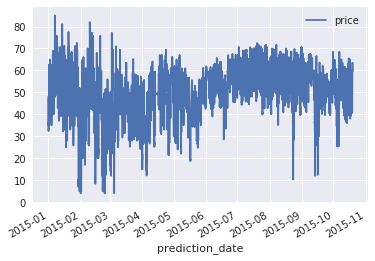

In [6]:
df.plot(x='prediction_date', y='price')

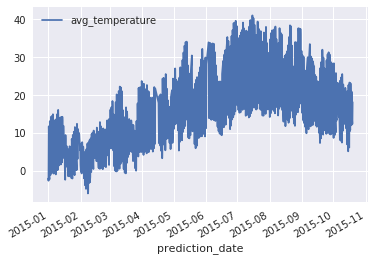

In [8]:
df.plot(x='prediction_date', y='avg_temperature')